INFO: Be concious that the number of layers passed is only for the encoder. The decoder will be its symetric
Loading data...
Restoring variables from: ../models/ckpts/
Error in the restore process. Initializing from scratch instead!

*************************************************************
Epoch 1/5
--> Global step:   468 - Mean loss: 373.2877  (18538.70, 1779715.52) (steps,images)/sec
[[0.7256403  0.2556658  0.5226992 ]
 [0.730879   0.25311428 0.53803784]
 [0.7295641  0.25221825 0.53301966]
 [0.72893834 0.26943463 0.53947705]
 [0.7261462  0.25580347 0.53052485]
 [0.7250572  0.26298752 0.5285906 ]
 [0.72461003 0.25794768 0.52149713]
 [0.72409517 0.2622404  0.5259215 ]
 [0.72800326 0.25316426 0.5353883 ]
 [0.7248376  0.25754973 0.5277659 ]
 [0.72139716 0.26206824 0.52887964]
 [0.71979094 0.26079795 0.51250553]
 [0.72011924 0.25461566 0.5324534 ]
 [0.7275436  0.26314527 0.53620297]
 [0.7198282  0.2532357  0.5299298 ]
 [0.7214011  0.2546177  0.5180521 ]
 [0.72524375 0.25880086 0.5339

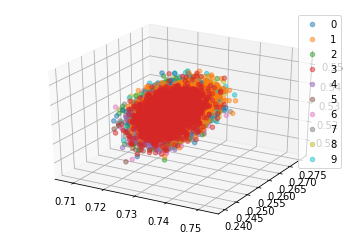

In [2]:
%matplotlib inline  
import sys
from datasets import *
from base import *
import  models
import logging
import utils
import os
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

logging.getLogger("tensorflow").setLevel(logging.ERROR)

hparams = Hyperparameters()
hparams.num_epochs = 5
hparams.batch_size = 96
hparams.initial_learning_rate = 1e-3
hparams.cut_layer = "pool4"
hparams.activation = "relu"
# hparams.batch_norm = "batc_norm"
hparams.hidden_layers = [512, 50,50]
hparams.fine_tunning = False
hparams.bottleneck = False
# hparams.keep = 0.5
# hparams.regularizer_type = 1
hparams.regularizer_scale = 0.6
os.system("rm -rf {}/Cifar10/*".format(hparams.checkpoints_path))

data = Cifar10(hparams, tfrecord = False)


# description = {"type":"sum", "num_models":3, "independent_inputs":False,    
#                                                "models":[
#                                                         {"model":models.Vgg16, "cut_layer":"pool4"},
#                                                         {"model":models.Vgg16, "cut_layer":"pool4"},
#                                                         {"model":models.Vgg16, "cut_layer":"pool4"},
#                                                         ]
#               }

# # ensamble = models.Ensamble(hparams,data, description)
# ensamble = models.Vgg16(hparams,data)

ensamble = models.Autoencoder(hparams,data)

ensamble.train()

# predictions = ensamble.test_prediction()
# utils.generate_confusion_matrix(predictions, hparams.class_names)

# import the inspect_checkpoint library
# from tensorflow.python.tools import inspect_checkpoint as chkp

# # print all tensors in checkpoint file
# chkp.print_tensors_in_checkpoint_file("./models/vgg_19.ckpt", '', True, False)
                               


In [ ]:

import numpy as np
x = predictions["probs"][5000]
sm= np.exp(x) / np.sum(np.exp(x), axis=0)

print(sm)

In [ ]:

x = np.random.random(100)
y = np.random.random(100)
c = np.random.choice(range(10), 100)

# plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
# plot x,y data with c as the color vector, set the line width of the markers to 0
ax.scatter(x, y, c=c, lw=0)

In [ ]:
a = list(range(5))
for i in a:
    if i == 0:
        del a[3]
    print i
    

In [ ]:
import numpy as np
import tensorflow as tf

def get_d_reg_kernel(kernel,w_inputs, w_output,  d, avgpool = False):
    if d == 0: d = 1
    
    default_value = 1.0 if not avgpool else 1./(kernel[0]**2)
    
    kernel =  [x*d-(d-1) for x in kernel]
    size = tuple( kernel + [w_inputs, w_output])
    
    if d > 1:
        init = np.zeros(size)
        ones = range(0,kernel[0],d)
        zeros = list(set(range(kernel[0])) - set(ones)) 
        init[ones,:,:,:] = default_value
        init[:,zeros,:,:] = 0

    else:
        init = np.ones(size) * default_value
    
    return init
    
def get_weights(w_inputs, w_output, kernel_size = [], d = 1, name = "conv/conv" ):
    xavier_init = tf.contrib.layers.xavier_initializer()
    
    init = get_d_reg_kernel(kernel_size,w_inputs, w_output, d)
    regularly_kernel = tf.constant(init, dtype = tf.float32, name="{}/{}_regularly".format(name, d))
    
        
    weights= tf.Variable(init, dtype = tf.float32, name="{}/weights".format(name))
    biases =  tf.Variable(xavier_init([w_output]), name="{}/biases".format(name))
    weights = tf.multiply(weights, regularly_kernel, name="{}/{}_regAplly".format(name,d))
    return weights, biases

def conv2d(x, out_channels, kernel,  name = "conv", d = 1, batch_norm = False, padding = "VALID"):
    depth = x.shape.as_list()[-1]  
    w, b = get_weights(depth, out_channels, kernel,d, name)
    x = tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], name = name, data_format= "NHWC", padding = padding)

    x = tf.nn.bias_add(x, b)
    x = tf.nn.relu(x)
    if batch_norm:
        x = self.batch_norm(x, "{}/batch_norm" % name)

    return x 

def avgpool(x, k = 2, d = 1):
    if d < 2:
        return tf.nn.avg_pool(x, ksize=[1, k, k, 1], strides=[1, 1,1,1], padding='VALID' )
    x = tf.transpose(x, [0,3,1,2])
    x = tf.expand_dims(x, 4)
    init = get_d_reg_kernel([k,k], 1, 1,  d, avgpool = False)
    print(np.squeeze(init))
    filter = tf.constant(np.expand_dims(init, 0), dtype =tf.float32)
    pool = tf.nn.conv3d(x, filter, [1,1,1,1,1], data_format= "NDHWC", padding='VALID', name="pool")
    pool = tf.transpose(pool, [0,2,3,1,4])

    return tf.squeeze(pool, [4])

input = tf.constant(np.zeros((1,32,32,3)), dtype =tf.float32)
conv = conv2d(input, 64, [3,3], d = 2, name = "conv",  batch_norm = False, padding = "VALID")
pool = avgpool(conv, k = 3, d = 1)

print(conv)
print(pool)

